# Droplets

This *jupyter* notebook carries out the analyses in the upcoming journal article focusing on analyzing gravitationally unbound, coherent structures with significant velocity gradients.  The notebook is edited to work with data and *Python* scripts in the [Github repo](https://github.com/hopehhchen/Droplets).

## 0. Abstract and Outlines

The project looks for coherent cores with significant velocity gradients in the L1688 region in Ophiuchus and the B18 region in Taurus, out of the four nearby star forming regions covered by the *GBT Ammonia Survey* (GAS) Data Release 1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)).  One goal of the project is to update numbers for physical properties of (potentially) rotational motions within these structures.  The relation between the velocity gradient and the size was first examined using observations of ammonia molecular line emission by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  With an improved physical resolution of ~4000 AU (the FWHM beam size at the distance of Ophiuchus and Taurus), we hope to provide more reliable and relevant numbers for simulations and analytical models, especially ones concerning with disk formation inside star forming cores.

Subsequent analyses included in this project discover that the structures are possibly gravitationally unbound, despite subsonic velocity dispersions and relatively high column densities.  The behavior is unexpected in the final stages of monolithic star formation driven by gravity.  Due to their small sizes and the seeming unboundness, we term these structures "droplets," to distinguish them from "cores," which are often used to indicate bound and star forming, sub-parsec structures.  The project aims at providing a guess to how the "droplets" are formed and what role they could play in the star formation process.

This notebook is organized as follows. In [***I. Identification of Structures***](#identification), we go through how we identify these structures and how we define the boundaries.  In [***II. Physical Properties of Droplets***](#properties), we derive the basic physical properties of the "droplets," based on the property maps from ammonia line fitting to the GAS DR1 data.  In ***III. Kinematics and Dynamics***, we look for possible explanations to the formation of "droplets" and the role they play in star formation.  In particular, we look into the spatial distribution of ram pressure within and around the "droplets," to see whether the droplets could be pressure-bound.  In all sections of this notebook, we also provide the codes to generate tables and plots that eventually appear in the corresponding parts of the article.

Further discussions are included in the article hosted on Authorea.  **This notebook, though filled with definitions essential for users to understand the analyses, is *not* meant to be complete or continuous as the journal article itself.**  Please look in the article for details.

***CAUTION: This is work in progress.***

[*The square brackets in this notebook host the technical explanations of following code cells.  They should be treated as code comments.*]

#### Authors
* **Hope Chen** (leading and corresponding, at <hhchen@cfa.harvard.edu>; Harvard-Smithsonian Center for Astrophysics)
* Jaime Pineda (Max-Planck-Institut für Extraterrestrische Physik)
* Alyssa Goodman (Harvard-Smithsonian Center for Astrophysics)
* Andreas Burkert (University Observatory Munich)

#### Code Dependencies
The version numbers listed below correspond to the versions used when this notebook is compiled.  Most *Python* packages are backward compatible, but there is no guarantee.  Please report problems via [the issue tracker of the Droplet repo](https://github.com/hopehhchen/Droplets/issues).
* `numpy`: v1.11.3
* `scipy`: v0.19.0
* `astropy`: v2.0.2
* `FITS_tools`: v0.0.dev
* `matplotlib`: v1.5.1
* `pandas`: v0.20.1

In [1]:
%matplotlib inline
import sys
import os

#
import numpy as np

#
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
import astropy.constants as c
#import astropy.visualization.wcsaxes as wcsaxes
import FITS_tools as fits_tools

#
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#
import pandas as pd

## 
from Droplets import *
from constants import *
import styles

#### Main Variables in this Notebook
The variables are derived along the way following the steps outlined above.  This list is just for bookkeeping.  (The attached link goes to the code cell where each variable is first defined.)
* [`dict_data`](#dict_data): The *Python* dictionary that stores the maps in "`./data/`".  The data are from the GAS DR1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)), with the original files stored in [this dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project).
* [`dict_masks`](#dict_masks): The *Python* dictionary that stores the masks for the target structures in "`./results/masks/`".
* [`dict_YSOs`](#dict_YSOs): The *Python* dictionary that sotres the YSO catalogs in "`./data/YSO_catalogs/`".  The catalogs are originally from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract), and include only Class 0/I and flat spectrum YSOs above certain "grades" assigned in the original works.  The original catalogs can be found on VizieR: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).
* [`dict_Vlsr_predicted`](#dict_Vlsr_predicted): The *Python* dictionary that stores the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits, in "`./results/Vlsr_predicted/`".  Details about fitting of $V_\text{LSR}$ can be found in [***II. Physical Properties of Droplets***](#properties).

## 0.1 Data and Targets

The GAS DR1 inlcudes observations of the ammonia hyperfine line emission made with the *Green Bank Telescope* (GBT).  By fitting Guassian profiles to the ammonia hyperfine lines, [Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) derive the property maps of four nearby star forming regions: B18 in Taurus, L1688 in Ophiuchus, NGC1333 in Perseus, and Orion A North.  These physical properties include the NH$_3$ velocity centroid (in the LSR frame; $V_\text{LSR}$), the NH$_3$ velocity dispersion ($\sigma_V$), the NH$_3$ column density ($N_{\text{NH}_3}$), the excitation temperature of NH$_3$ hyperfine lines ($T_\text{ex}$), and the kinetic temperature ($T_\text{kin}$).  Besides property maps included as part of the GAS DR1, we also derive the peak main beam temperature from the trimmed and baseline subtracted data cubes from observations of NH$_3$ (1, 1) hyperfine lines.  We look for coherent structures using these physical properties in the B18 region and the L1688 region, where their proximity (at the distances of ~135 and ~137.3 pc, respectively; [Schlafly et al., 2014](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract); [Ortiz-León et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract)) grants us the highest physical resolution (the GBT FWHM beamsize of 32" at 23 GHz corresponds to ~4300 AU).

[*The Python dictionary `distances` stores the distances that are used throughout this paper, in the formats of `astropy.units`.  The code cell below is for demonstrative purpose; for a complete list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [2]:
distances = {'L1688': 137.3*u.pc, 'B18': 135.*u.pc}

The GAS data are supplemented by the column density and dust temprature maps derived using *Herschel* observations of dust continuum emission.  The *Herschel* observations were made as part of the *Herschel Gould Belt Survey* (GBS; [André et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010A&A...518L.102A/abstract)), and the data are from the *Herschel* Science Archive.  The FWHM beamsize of SPIRE 500 µm is 36", which matches well with the GBT beamsize.

The full GAS DR1 dataset is hosted on [Dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), which includes the original data cubes from GBT observations of various molecular lines.  The peak main beam temperature maps were not included in the set of property maps in the GAS DR1, but were instead derived from the trimmed and baseline subtracted data cubes.  Due to the github policy for large data files, the  [Droplets github repo](https://github.com/hopehhchen/Droplets) includes only the data maps that are needed in the analyses, but not the data cubes from which the property maps were derived.

[*The datasets are read and stored in `dict_data`.  The maps of error in each phsyical property were produced for the GAS DR1 alongside the property maps, and are stored in `dict_data` with a prefix "`e`".  The property maps in the GAS DR1 are flagged by the detection level and the goodness of the fit.  In the array directly read in from files in [this github repo](https://github.com/hopehhchen/Droplets) and in the [GAS DR1 dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), the flagged pixels within the observed areas have values of 0.  In the following code cell, we remove the flags by converting them to NaN values, for the ease of future calculation.  This is not done for the maps of the peak main beam temperature, which is derived from the data cubes that include the full observed areas.*]
<a id='dict_data'></a>

In [3]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'
## lists of property maps to be read in
list_propertiesGAS = ['Vlsr', 'Sigma', 'N_NH3', 'Tex', 'Tkin']
list_propertiesHerschel = ['colden', 'temp']


# Read the data.
dict_data = {'L1688': {}, 'B18': {}}
for reg in ['L1688', 'B18']:
    
    # GAS DR1 Property Maps
    for prop in list_propertiesGAS:
        ## data
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg][prop] = data
        
        ## error maps
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_e'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg]['e'+prop] = data
    ## header
    dict_data[reg]['header_GAS'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Vlsr_DR1_rebase3_flag.fits')[0].header
    
    # GAS DR1 Peak Main Beam Temperature
    dict_data[reg]['Tpeak'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Tpeak_DR1_rebase3_trim.fits')[0].data
    
    # Herschel
    for prop in list_propertiesHerschel:
        dict_data[reg][prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_masked.fits')[0].data
    ## header
    dict_data[reg]['header_Herschel'] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_colden_masked.fits')[0].header

Several properties that are immediately derivable from the property maps include the total velocity dispersion ($\sigma_\text{tot}$) and its thermal and non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$, respectively).  These can be derived from the NH$_3$ linewidth ($\sigma_{\text{NH}_3}$) and the kinetic temperature of the gas ($T_\text{kin}$), assuming that different species of molecules are at a thermal equilibrium.  The equation used here is: $$\sigma_\text{tot}^2 = \sigma_{\text{NH}_3}^2 - \frac{k_B T_\text{kin}}{m_{\text{NH}_3}} + \frac{k_B T_\text{kin}}{\mu m_\text{H}} \text{,}$$ where $m_{\text{NH}_3}$ is the molecular weight of NH$_3$ and $\mu m_\text{H}$ is the average particle weight in the atomic mass unit (a.m.u.).  Throughout this paper, we use $\mu = 2.37$ based on the results presented by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract), and $m_{\text{NH}_3} = 17.031\ \text{a.m.u.}$ according to the [IUPAC value](https://pubchem.ncbi.nlm.nih.gov/compound/ammonia#section=Top).

[*The derived properties: $\sigma_\text{tot}$, $\sigma_\text{T}$, and $\sigma_\text{NT}$ are stored in the same dictionary: `dict_data`.  The following code cell might generate a `RuntimeWarning` regarding invalid value encoutered in sqrt, which by default would simply produce a NaN value at the pixel(s).  The warning message is due to the unlikely event where the observed NH$_3$ linewidth is narrower than the thermal linewidth of the NH$_3$ molecules expected at the observed kinetic temperature.  This happens only at ~0.01% of the sky areas observed in the L1688 and B18 regions combined.  The definition of the variable `mass` below is merely for demonstrative purpose.  For the full list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [4]:
# mass for the NH3 molecule and an average particle in ISM
mass = {'NH3': 17.031*u.u, 'average': 2.37*u.u}


# Derive the total velocity dispersion, and its thermal and non-thermal components.
for reg in ['L1688', 'B18']:
    
    # NH3 linewidth and kinetic temperature from GAS DR1
    sigmaNH3 = dict_data[reg]['Sigma']
    Tkin = dict_data[reg]['Tkin']
    
    
    # derived properties
    ## thermal and non-thermal components
    sigmaNT = np.sqrt((sigmaNH3*u.km/u.s)**2. - c.k_B*Tkin*u.K/mass['NH3']).to(u.km/u.s).value
    sigmaT = np.sqrt(c.k_B*Tkin*u.K/mass['average']).to(u.km/u.s).value
    ## total velocity dispersion
    sigmaTot = np.sqrt((sigmaNT*u.km/u.s)**2.+(sigmaT*u.km/u.s)**2.).to(u.km/u.s).value
    
    
    # store the derived maps
    dict_data[reg]['SigmaNT'] = sigmaNT
    dict_data[reg]['SigmaT'] = sigmaT
    dict_data[reg]['SigmaTot'] = sigmaTot

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in sqrt


For easier comparison between the GAS DR1 data and the *Herschel* maps, we project the *Herschel* maps to the GAS DR1 grid.  As mentioned above, the GBT has a FWHM beamsize at 23 GHz (32") similar to the FWHM beamsize of *Herschel* 500 µm (36").  Thus, we can safely assume that the regridding does not introduce a significant biase.

[*The regridding is done using the *Python* package [`FITS_tools`](http://fits-tools.readthedocs.io/en/latest/fits_tools.html).  The newly projected images replace the original images in `dict_data`.*]

In [5]:
# Regrid the Herschel maps.
for reg in ['L1688', 'B18']:
    
    for prop in list_propertiesHerschel:
        
        # Regrid using hcongrid.
        image = dict_data[reg][prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg][prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)

In the analyses below, we use YSO catalogs from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract) to determine the existence of YSO sources potentially associated with target structures in Ophiuchus and in Taurus, respectively.  Parsed versions of the catalogs that include only Class 0/I and flat spectrum YSOs, above certain "grades" of reliability assigned in the papers just mentioned, can be found in [the data folder of this github repo](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/YSO_catalogs).  The original, full catalogs can be found on [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR) on the corresponding catalog pages: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).

The parsed versions of the catalogs include only Class 0/I and flat spectrum YSOs (according to the definitions in the corresponding papers mentioned above), which are not AGBs in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) nor below the rank "A-" in [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract).  There is information about the coordinates, the object names in the original surveys, and the classification in the catalogs.  In the case of [`L1688.csv`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/YSO_catalogs/L1688.csv), the column "`alpha_prime`" corresponds to the extinction corrected spectral index, $\alpha^\prime$, in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), and is used to determine the class of the YSOs.  According to [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), YSOs with $\alpha^\prime \geq 0.3$ belong to Class 0/I, and YSOs with $0.3 > \alpha^\prime \geq -0.3$ belong to the "flat spectrum" category.

[*Since only the pixel coordinates on the GAS data projection are needed, the celetial coordinates are converted using the GAS headers before being stored in `dict_YSOs`.  The resulting array of pixel coordinates has a length of the number of YSOs in the catalog and a width of two corresponding to the x (Axis 1 in a numpy array) and the y (Axis 0 in a numpy array) coordinates.*]
<a id='dict_YSOs'></a>

In [6]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'

# Read the data.
dict_YSOs = {}
for reg in ['L1688', 'B18']:
    
    ## catalogs
    catalog = pd.read_csv(direcData+'YSO_catalogs/'+reg+'.csv')
    
    ## header used for converting YSO coordinates to pixel coordinates
    header = dict_data[reg]['header_GAS']
    
    ## Convert YSO coordinates to pixel coordinates
    projection = wcs.WCS(header)
    dict_YSOs[reg] = projection.wcs_world2pix(np.c_[catalog['RA'].values, catalog['Dec'].values], 0)

<a id='identification'></a>
## I. Identification of Structures

We look for coherent structures ([Goodman et al., 1998](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract)) in the L1688 region in Ophiuchus and the B18 region in Taurus.  [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract) proposed that these coherent structures represent the smallest scale in the self-similar process of star formation in turbulent clouds, within which the dominant gravity drives the final stage of star formation.  The coherent structures are defined by a boundary of sharp transition in linewidth, from supersonic linewidths outside to subsonic linewidths inside the coherent structures.  Thus, our selection and definition of target structures are based on comparison between the thermal ($\sigma_\text{T}$) and non-thermal ($\sigma_\text{NT}$) components of velocity dispersion.  We also look for coherent structures that also show a local peak in column density.

Note that [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) did not impose a criterion regarding the velocity dispersion when selecting targets.  In this paper, since we intend to look for structures much smaller than the targets observed by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) and often more embedded within star forming regions, we try to avoid line of sight confusion by choosing only coherent structures.

[*The following code cell read in results that will be explained later in this notebook, including the masks for the target structures and the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits.  The process of defining the boundary will be explained in [this section](#identification).  On the other hand, fitting of the velocity gradient is done in [the next section](#properties), and the maps of the predicted $V_\text{LSR}$ are read in here just for the ease of examination of how good a single linear velocity gradient could fit the $V_\text{LSR}$ field within each structure.*]
<a id='dict_masks'></a> <a id='dict_Vlsr_predicted'></a>

In [7]:
# directory to the masks
direcMasks = os.getcwd()+'/results/masks/'
dict_masks = {'L1688': {}, 'B18': {}}
# directory to the maps of predicted Vlsr
direcResults = os.getcwd()+'/results/Vlsr_predicted/'
dict_Vlsr_predicted = {'L1688': {}, 'B18': {}}

# Read in the maps.
for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        listStructures = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listStructures = range(1, 7)
        
    for structure in listStructures:
        ## masks
        dict_masks[reg][structure] = fits.open(direcMasks+reg+'/'\
                                               +reg+'_'+str(structure)+'.fits')[0].data.astype(bool)
        
        ## predicted Vlsr
        dict_Vlsr_predicted[reg][structure] = fits.open(direcResults+reg+'/'\
                                                        +reg+'_'+str(structure)+'_Vlsr_predicted.fits')[0].data

The quantitative criterion for defining the boundary of each target structure varies slightly from structure to structure, depending on the local environment each core sits in.  The boundary is built following the steps below:

1. <a id='step1'></a>Start with the contour where the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, is equal to the velocity dispersion one would expect from when the velocity dispersion non-thermal component is the same as the sound speed of an average particle, $$\sigma_\text{NT} = c_\text{s, ave} \text{.}$$

2. <a id='step2'></a>If the contour forms a closed shape, and the shape contains a region with a condensed spatial distribution of the NH$_3$ (1, 1) peak main beam temperature, $T_\text{peak}$, and a constrained range of velocity centroids, $V_\text{LSR}$, then the contour is used to define the boundary of the structure.  This means that the boundary is coincident to either or both of the following: a) a significant increase in $T_\text{peak}$, or b) a significant change in $V_\text{LSR}$.

3. And, if the criteria in [Step 2](#step2) can be achieved by manually editing (adding or removing pixels from) the mask by less than 10% of the area, then the edited mask is used as the boundary of the structure.  

4. If the criteria in [Step 2](#step2) cannot be achieved by manually editing the mask, then a contour of constant $T_\text{peak}$ and/or a range of $V_\text{LSR}$ around the median velocity centroid in the original mask are used to define the structure.  This situation often happens when the original contour is too spatially extended or has a hole near the center of the target region.

5. Note that neither the *Herschel* column density map nor the *Herschel* dust temperature map is quantitatively used in defining the boundary.  The *Herschel* maps are but instead used to examine potential contamination from embedded sources, and to confirm that the boundary centers around a local rise in column density and a drop in dust temperature.

6. Lastly, the size of the resulting structure has to be larger than the size of the GBT beam at 23 GHz (~32") in both the R.A. and the Dec. directions.

As a result, we include 12 structures in L1688 and 6 structures in B18.  (See [Figure 1](#fig-droplet) for an example of such structure; see [Figure 2](#fig-skymaps) for all the structures in either region, plotted on top of several key property maps.)  There could potentially be more structures that satisfy the criteria above, but based on the GAS maps, these structures are probably more embedded in the star forming clusters and could suffer from contamination along the line of sight.  We include an "extra" structure in the L1688 region, which is isolated and has a clear velocity gradient, but does not have a subsonic linewidth.  This "extra" structure is include for the purpose of comparison.

[**Figure 1.**](#fig-droplet)<a id='fig-droplet'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), the velocity centroids ($V_\text{LSR}$), and the predicted velocity centroid from a 2D linear fit to the observed velocities, of a target structure.**  The thick contour marks the boundary of the droplet in view.  The thin red contours on the $\sigma_{\text{NH}_3}$ map is where the NH$_3$ linewidth equals to the linewidth expected from a line with a sonic non-thermal component (see [Step 1 above](#step1)).  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  [***Change the code to view another structure.  The first input is the region ("L1688" or "B18"), and the second input is the structure number (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/droplets/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/droplets).***]

[*The following code cell could generate a `RuntimeWarning` due to a conditional statement that compares the map of NH$_3$ linewidth, $\sigma_{\text{NH}_3}$, and the linewidth expected from when the non-thermal component is equal to the sound speed of an average particle, $\sigma_\text{NT} = c_\text{s, ave}$.  Such comparison is invalid when the pixels have NaN values, where the pixels are flagged.  The plotting is wrapped in the `plotDroplet` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py), and please modify to your own taste.  The plots included in the paper are based on the plot generated in the same way, but with annotations made outside this ipython notebook (in macOS Keynote).*]

Droplets.py:346: RuntimeWarning: invalid value encountered in less
  axis.contour((list_images[i] < NT_sonic),
//anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1018: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


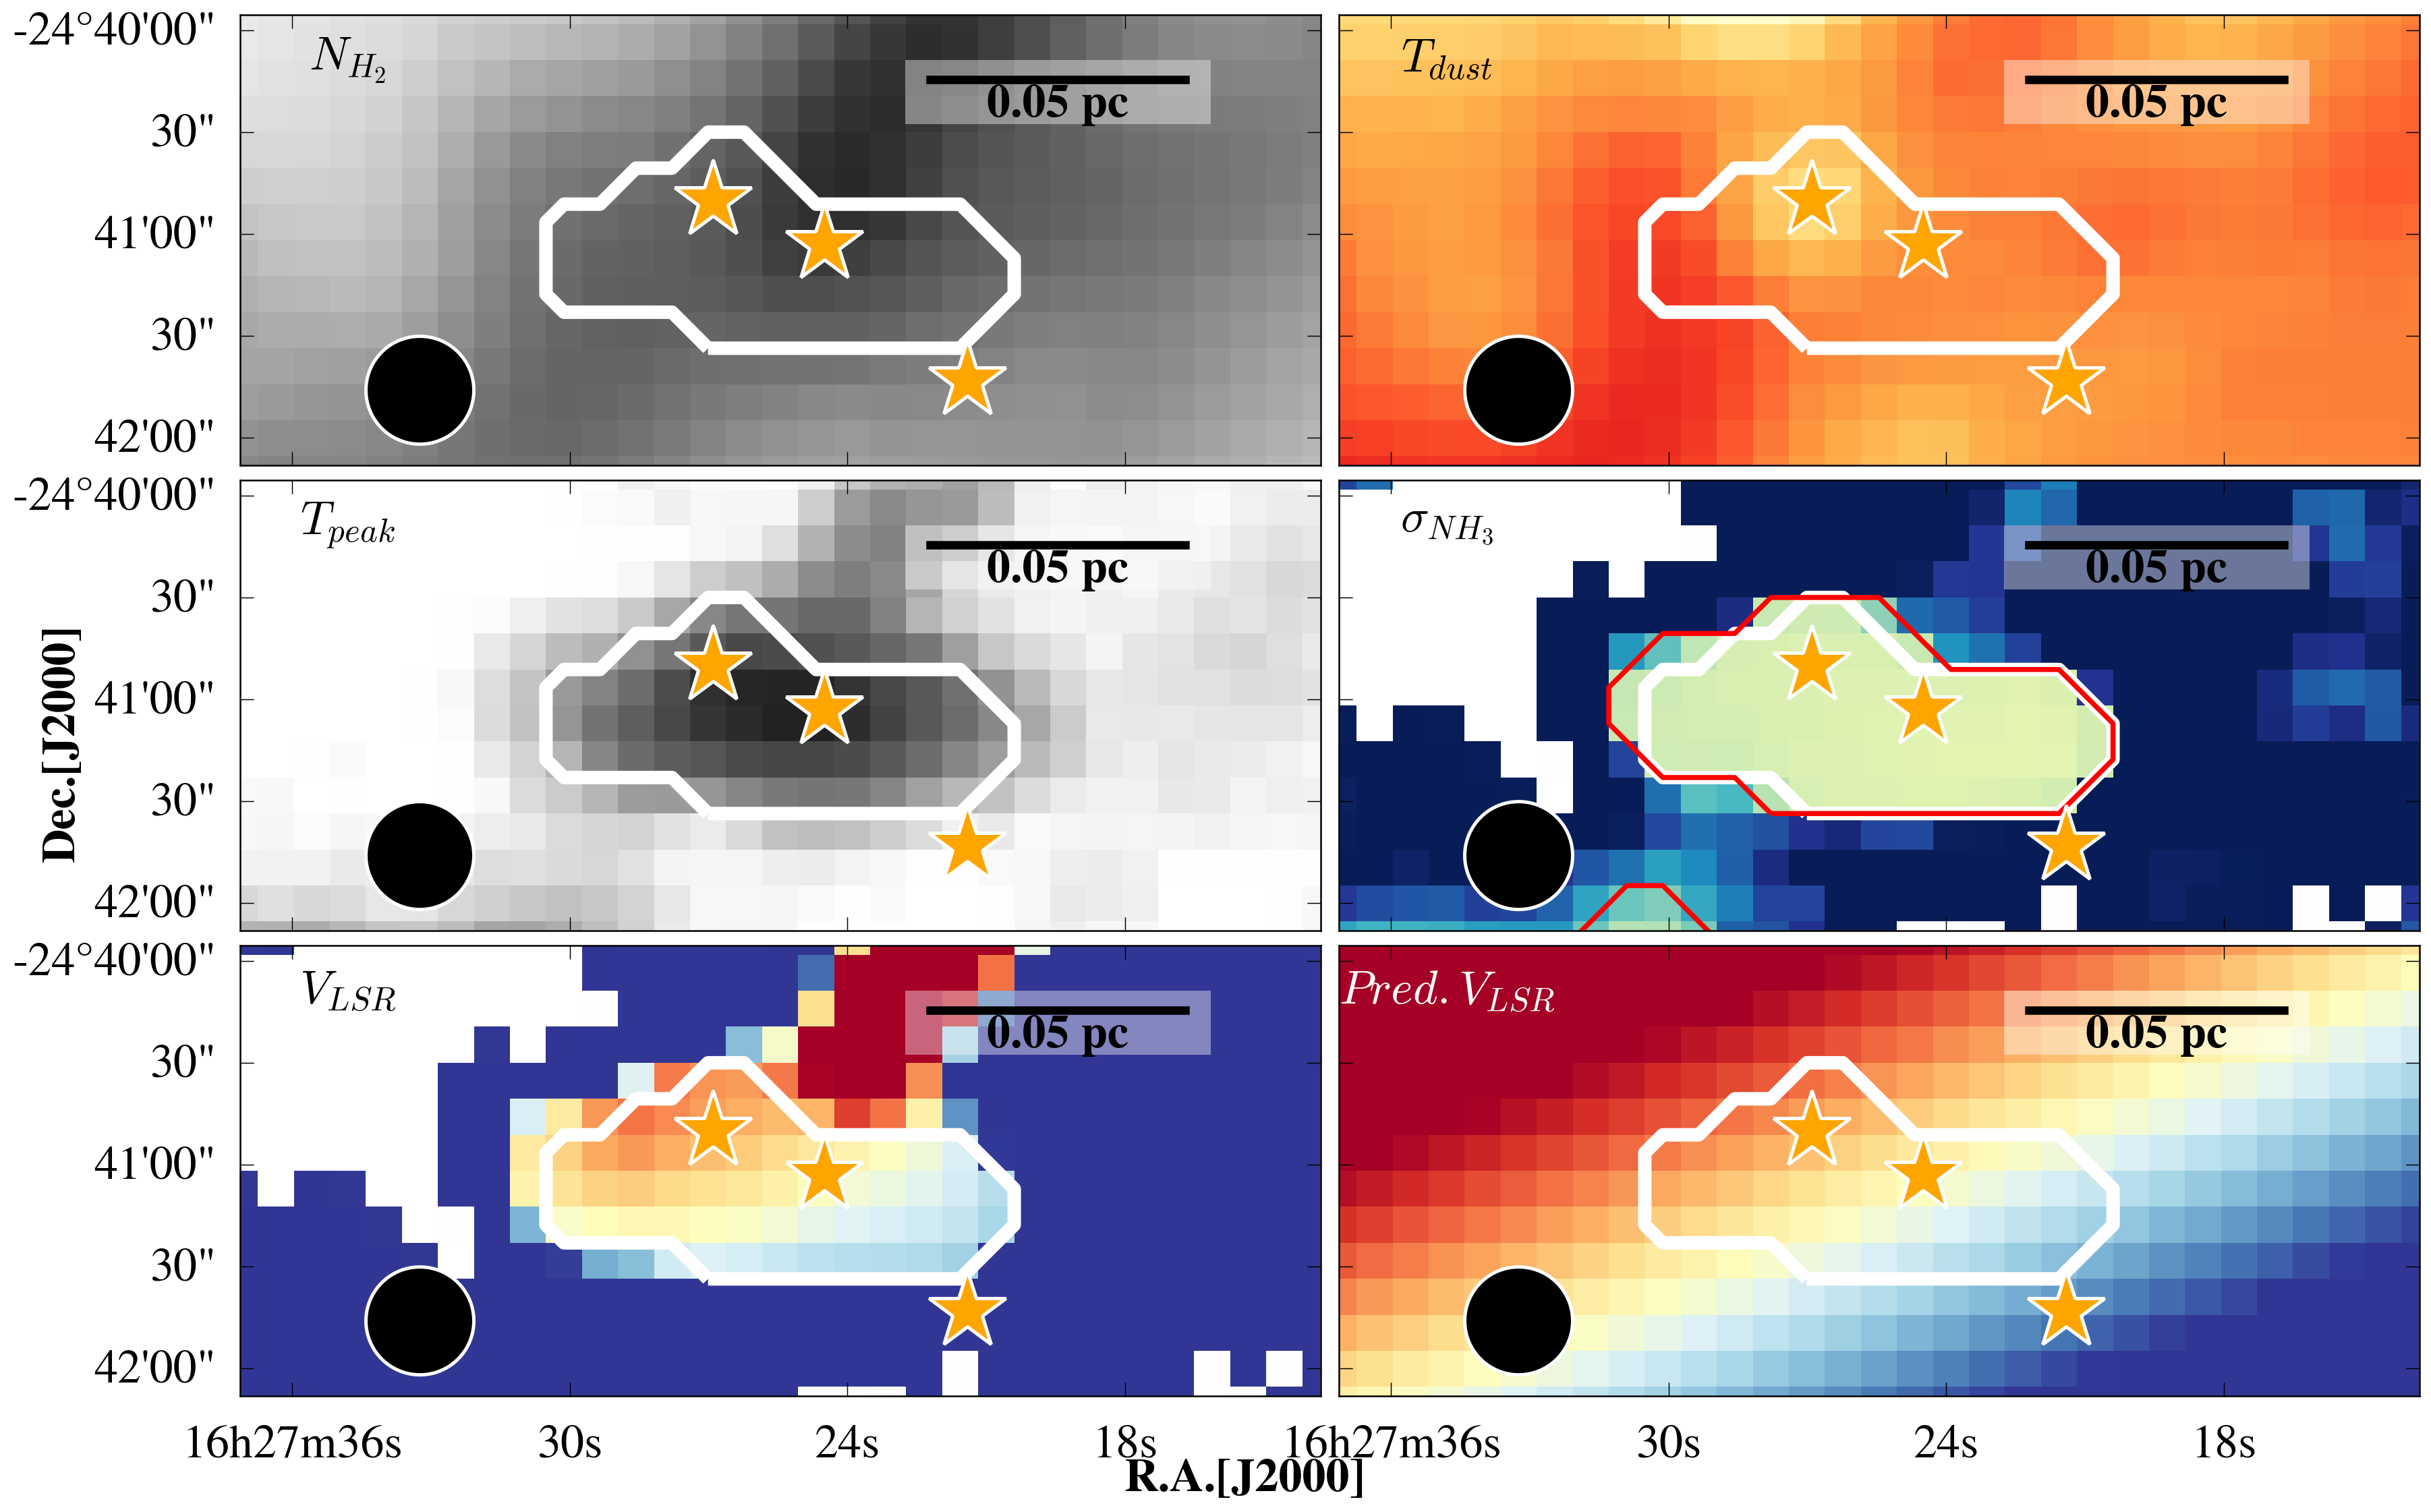

In [8]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotDroplet('L1688', 6, list_dictionaries)  ## <<< Change the code in this line!

[**Figure 2.**](#fig-skymaps)<a id='fig-skymaps'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ kinetic temperature ($T_\text{kin}$), the velocity centroids ($V_\text{LSR}$), and the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), of the entire region.**  The colored contours mark the boundaries of the droplets in the region.  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  *User's choice: A box could be plotted to highlight the region shown in [Figure 1](#fig-sroplet).*  [***Change the code to view either L1688 or B18 (the first input of the function "`plotRegion`".  Input a structure number to the variable "`chooseStructure`" to highlight the structure (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots).***]

[*The code for plotting this figure is wrapped in the `plotRegion` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

//anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1018: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


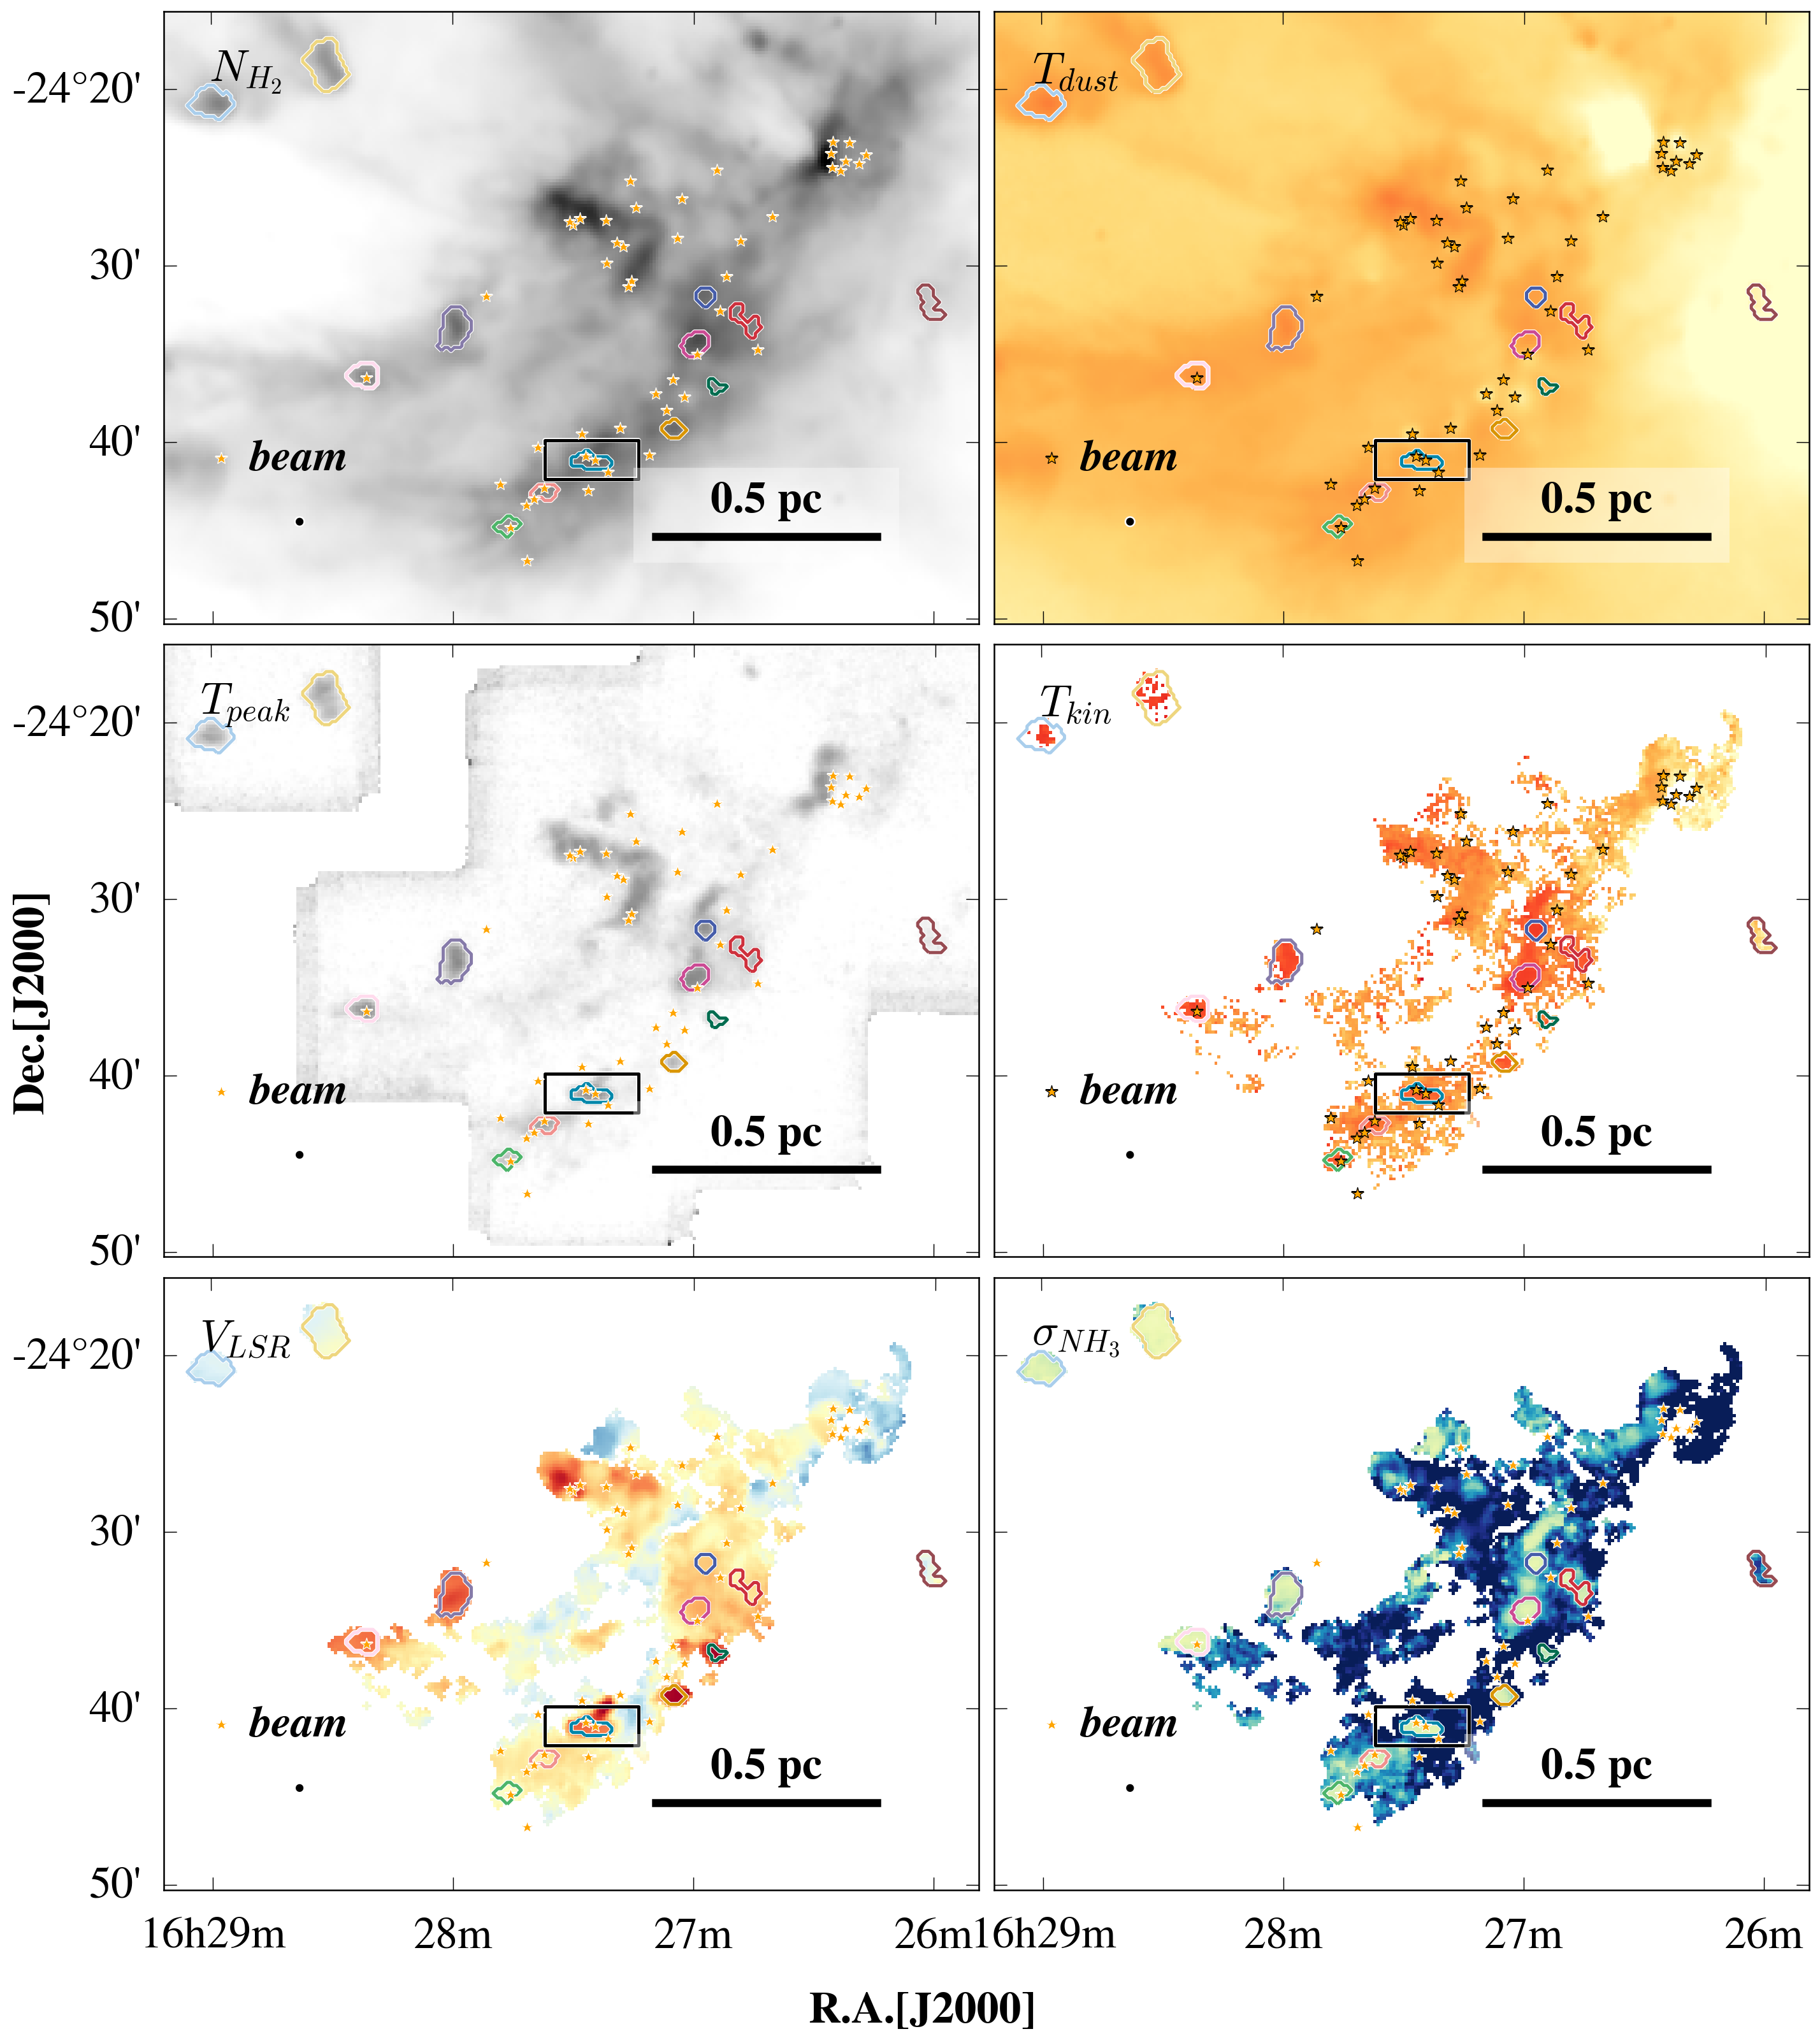

In [8]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotRegion('L1688', list_dictionaries, chooseStructure = 6)  ## <<< Change the code in this line!

<a id='coherence'></a>
### I.1 The *Coherence* of the Structures

Since [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract), multiple attempts to observe the coherent cores have been made, including the one made by [Caselli et al. (2002)](https://ui.adsabs.harvard.edu/#abs/2002ApJ...572..238C/abstract).  As described in the previous paragraphs, one key property of such coherent cores is a sharp transition from supersonic velocity dispersion outside the core to subsonic velocity dispersion inside.  In the first direct observations of a coherent core in the B5 region in Perseus, [Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract) shows that the NH$_3$ velocity dispersion decreases with increasing peak antenna temperature around the coherent core ([Figure 4 in Pineda et al., 2010](http://www.astroexplorer.org/details/apjl340752f4)).  Here we examine L1688 and B18 in similar plots of the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, and the peak main beam temperature, $T_\text{peak}$, in [Figure 3](#fig-banana).  We find that a similar trend exists for the L1688 and B18 regions.  We also find that the target structures defined in [Section I](#identification) sits at the low velocity dispersion-high peak main beam temperature end of the trend, just like the coherent core in B5 observed by [Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract).

[**Figure 3.**](#fig-banana)<a id='fig-banana'></a> The banana plots for both regions.

[**Figure 4.**](#fig-sigmaProfile)<a id='fig-sigmaProfile'></a> The radial profile of velocity dispersion in each droplet.

<a id='properties'></a>
## II. Physical Properties of Droplets

In [41]:
dict_Vlsr_predicted = {'L1688': {}, 'B18': {}}

for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        listCores = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listCores = range(1, 7)
    header = dict_data[reg]['header_GAS']
        
    for core in listCores:
        mask = dict_masks[reg][core]
        Vlsr, eVlsr = dict_data[reg]['Vlsr'], dict_data[reg]['eVlsr']
        
        Vlsr_predicted = fitGradient(mask, Vlsr, eVlsr)[2]  ## `fitGradient` function is in `Droplets.py`.
        dict_Vlsr_predicted[reg][core] = Vlsr_predicted